In [1]:
from OpenMiChroM.ChromDynamics import MiChroM
from openmmtools import integrators
from simtk import unit
from Custom_integrators import CustomBrownianIntegrator
import Custom_Bonds
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc

In [12]:
ftop='chr_top.txt'
fseq='chr_seq1000AB.txt'
finit='snap_1000AB.npy'

Ta=10
Na=0
T=20
F=0.0
Esoft=10

R0=100
gamma=0.1
kb=1
dt=0.001
nblocks=200
blocksize=100
opath='output/'
savename='test'

In [13]:
#==========================#
#Initialize Michrom Class  #
#==========================#
sim=MiChroM(name=savename, velocity_reinitialize=False,temperature=T)

#Specify integrator
integrator=CustomBrownianIntegrator(
                    timestep=dt * unit.picoseconds, 
                    collision_rate=gamma / unit.picoseconds,
                    temperature=(T/0.0083) * unit.kelvin,measure_heat=False,
                    noise_corr=Ta * unit.picoseconds,
                    )

sim.setup(platform="opencl",integrator=integrator,)
sim.saveFolder(opath)

#Initial structure (spiral by default)
if '.npy' not in finit:
    chrm=sim.create_springSpiral(ChromSeq=fseq)
else:
    chrm=np.load(finit)
sim.loadStructure(chrm,center=True)
sim._translate_type(fseq)


    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.2 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

In [9]:
Custom_Bonds.set_activity(sim,F_act=0, particle_list=[])


##---------#
##polymers #
##---------#

#chromosome topology
chrm_top=np.loadtxt(ftop, delimiter=' ', dtype=int)
# sim.forceDict['HarmonicBond']=sim.mm.HarmonicBondForce()
##add bonds between nearest neighbors
for ii in range(sim.N-1):
    #skip bonds between different chromosomes
    if ii in chrm_top[:,1]: continue
    # Custom_Bonds.addTanhHarmonicBond(sim, ii, ii+1, eh=20, kb=kb)
    # print(ii)
    # sim.forceDict['HarmonicBond'].addBond(ii,ii+1, 2, 1)
    # sim.bondsForException.append((int(ii), int(ii+1)))
    Custom_Bonds.addHarmonicBond(sim, ii, ii+1, kb=kb, d=2) 

# Custom_Bonds.addRadialConfinement(sim, R0=100, FlatBottomHarmonic=True, kr=20)

#=====================#
# Soft-core repulsion #
#=====================#
# Custom_Bonds.addTanhRepulsion(sim, es=4,rc=1)

#=========================#
# Inter-monomer adhesion  #
#=========================#
# sim.addCustomTypes(mu=3, rc=1, TypesTable='type_table.csv')
Custom_Bonds.addCustomTypes(sim,rc=2,TypesTable='type_table.csv')


In [10]:
# for key in sim.forceDict:
#     print(key, sim.forceDict[key].getForceGroup(),sim.forceDict[key].getNumParticles(),
#     sim.forceDict[key].getNumPerParticleParameters(),sim.forceDict[key].getParticleParameters(70))
# print(sim.forceDict['CustomTypes'].getParticleParameters(200))
# print(sim.forceDict['ActiveForce'].getNumParticles())
# sim.forceDict['HarmonicBond'].getGlobalParameterDefaultValue(1,)
# sim.forceDict['HarmonicBond'].getNumBonds()
# sim.forceDict['HarmonicBond'].getNumGlobalParameters()
# print(chrm_top.shape)

In [11]:
positions=[]
for ii, _ in enumerate(range(nblocks)):
    sim.runSimBlock(blocksize)
    #sim.saveStructure()

    state = sim.context.getState(getPositions=True,
            getVelocities=True, getEnergy=True)
    #vel = state.getVelocities(asNumpy=True)#/unit.sqrt(unit.kilojoule_per_mole / mass)
    positions.append(state.getPositions(asNumpy=True))
    sim.printForces()
    print(sim.state.getPotentialEnergy(), sim.kB*T*unit.kelvin)
    
    # if ii%int(args.nblocks*0.1)==0 and ii>0==0:
    if ii==500:
        np.save(opath+'traj_'+savename+'_positions.npy',np.array(positions))
        print('saved')
#save cndb file
#sim.storage[0].close()

#np.save(args.opath+savename+'_velocities.npy',Velocities)
np.save(opath+'traj_'+savename+'_positions.npy',np.array(positions))

Number of exceptions: 0
adding force  ActiveForce 0
Add exclusions for CustomTypes force
adding force  CustomTypes 1
Positions... 
 loaded!
potential energy is -54.065270
bl=1 pos[1]=[-31.8 -69.4 -62.5] dr=10.76 t=0.0ps kin=0.00 pot=-3.04 Rg=75.979 SPS=256 
                                  Values
ActiveForce                     0.000000
CustomTypes                 -3035.974854
Potential Energy (total)    -3035.974854
Potential Energy (per loci)    -3.035975
-3035.974853515625 kJ/mol 166.2892523630648 J/mol
bl=2 pos[1]=[-37.3 -69.9 -71.8] dr=10.81 t=0.0ps kin=0.00 pot=-0.49 Rg=76.915 SPS=733 
                                 Values
ActiveForce                    0.000000
CustomTypes                 -494.897003
Potential Energy (total)    -494.897003
Potential Energy (per loci)   -0.494897
-494.8970031738281 kJ/mol 166.2892523630648 J/mol
bl=3 pos[1]=[-24.0 -67.1 -69.7] dr=10.94 t=0.0ps kin=0.00 pot=-0.91 Rg=77.473 SPS=853 
                                 Values
ActiveForce            

In [27]:
xyz=np.load(opath+'traj_'+savename+'_positions.npy')
print(xyz.shape)

(1000, 1000, 3)


In [27]:
np.save('snap_1000AB.npy',xyz[-1])

In [7]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_axes([0,0,2,2],projection='3d')
# ax = fig.add_axes([0,0,1,1],)
# quiver = ax.quiver([],[],[],[])
#quiver = ax.quiver([],[],[],[],[],[])
R0=100
Na=400
ax.scatter(xyz[0,:Na,0],xyz[0,:Na,1],xyz[0,:Na,2],'o',color='C0')
ax.scatter(xyz[0,Na:,0],xyz[0,Na:,1],xyz[0,Na:,2],'o',color='C1')
# c=['r','g','b']
def update(ii):
    fig.clear()
    ax = fig.add_axes([0,0,1,1],projection='3d')
    # ax = fig.add_axes([0,0,1,1],)

    p=xyz[ii]
    # print(p.shape)
    # line.set_data(p[:,0],p[:,1])
    # line.set_3d_properties(p[:,2])
    # plt.draw()
    # ax.plot(p[10:13,0],p[10:13,1],p[10:13,2],'o',color='C0',alpha=1)
    ax.scatter(p[:Na,0],p[:Na,1],p[:Na,2],'o',color='C0',alpha=0.5)

    # ax.plot(p[300:303,0],p[300:303,1],p[300:303,2],'o',color='C1',alpha=1)
    ax.scatter(p[Na:,0],p[Na:,1],p[Na:,2],'o',color='C1',)
    ax.plot(p[Na:,0],p[Na:,1],p[Na:,2],'-',color='k',)
    # ax.plot(masked_xyz[:100,0],masked_xyz[:100,1],'go',markersize=3)
    
    ax.set_zlim(-R0, R0)
    ax.set_xlim(-R0, R0)
    ax.set_ylim(-R0, R0)
    
    # return line,

#update(10)
ani = FuncAnimation(fig, update, frames=np.arange(1,xyz.shape[0],5), interval=200, blit=True,repeat=False)

# ani.save('ani_sticky_gas_T0.1_F0.1_Ta10-R20.gif', writer='pillow')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [87]:
def autocorrFFT(x):
    Nx=len(x)
    F = np.fft.fft(x, n=2*Nx)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:Nx]).real   #now we have the autocorrelation in convention B
    n=Nx*np.ones(Nx)-np.arange(0,Nx) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A
    
def msd_fft(r):
    Nx=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(Nx)
    for m in range(Nx):
        Q=Q-D[m-1]-D[Nx-m]
        S1[m]=Q/(Nx-m)
    return S1,S2

def tau_p(p1,k1,Nn):
    g=0.1
    return g*Nn**2/(np.pi**2*k1*p1**2)
    
def tau_charac(k1):
    g=0.1
    return g/(np.pi**2*k1)

def XP_autocorr(t,p1,T1,F1,ta,k1,Nn):
    g=0.1
    tp=tau_p(p1,k1,Nn)
    r=1-ta**2/tp**2
    ret = ((3*tp/(2*Nn*g))*(T1+F1**2*ta/(g*r))*np.exp(-t/tp) 
            - (3*F1**2*ta**2/(2*Nn*g**2*r))*np.exp(-t/ta))
    # ret=((3*temp*tp/(2*Nn*g))*np.exp(-t/tp)
    #         + (3*(F1*tp*ta)**2/(2*Nn*g**2*(tp**2-ta**2)))*(tp*np.exp(-t/tp)/ta + np.exp(-t/ta)))
    return ret

def Rot_corr(t,T1,F1,ta,k1,Nn):
    #scalar t
    ps=np.arange(1,Nn,1)
    ret=XP_autocorr(t,ps,T1,F1,ta,k1,Nn)*(1+np.cos(ps*np.pi/Nn)**2-2*np.cos(ps*np.pi)*np.cos(np.pi*ps/Nn))
    return np.mean(ret)

def dXp_autocorr(t,p1,T1,F1,ta,k1,Nn):
    #scalar t
    c=0
    tp=tau_p(p1,k1,Nn)
    g=0.1
    if t<1e-8: c=T1/(Nn*g)

    # ret=c-T1*np.exp(-t/tp)/(2*Nn*g*tp)
    ret=(c+XP_autocorr(t,p1,T1,F1,ta,k1,Nn)/tp**2-T1*np.exp(-t/tp)/(Nn*g*tp)
            +(F1**2*(ta**2+tp**2)*np.exp(-t/ta) -2*F1**2*ta*tp*np.exp(-t/tp))/(2*Nn*g**2*(tp**2-ta**2)))
    return ret
    

0.025330295910584444


(0.0, 0.001)

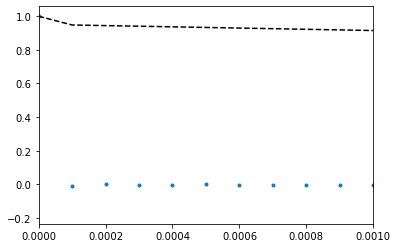

In [88]:

ts=np.arange(0,xyz.shape[0],1)*blocksize*dt
k=16#chrm_top.shape[0]
N=50#int(sim.N/k)
p=10
for d in [1]:
    SXp=[]
    print(tau_p(p,kb,50))
    for pol in range(k):
        # print(pol*N,(pol+1)*N)
        Xp=(1/N)*np.einsum('ijk,j->ik',xyz[:,pol*N:(pol+1)*N,:],np.cos((p*np.pi/N)*(np.arange(1,N+1,1)+0.5)))
        # print(Xp.shape)
        dXp=(Xp[d:,:]-Xp[:-d,:])/(blocksize*dt)
        
        SXp.append(msd_fft(dXp)[1])
    
    SXp=np.mean(np.array(SXp),axis=0)

    plt.semilogx(ts[:-d], SXp/SXp[0],'.')
    # if p==0: continue
    # plt.semilogx(ts,XP_autocorr(t=ts,p1=p,T1=T,F1=F,ta=Ta,k1=kb,Nn=50),'k--')
    plt.plot(ts,[dXp_autocorr(xx,p1=p,T1=T,F1=F,ta=Ta,k1=kb,Nn=50)/dXp_autocorr(0,p1=p,T1=T,F1=F,ta=Ta,k1=kb,Nn=50) for xx in ts],'k--')

# plt.loglog()
plt.xscale('linear')
# print(SXp.shape)
plt.xlim(0,0.001)
# plt.ylim(-100,200)

In [44]:
np.gradient(ts)

array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001])

(1e-05, 100.0)

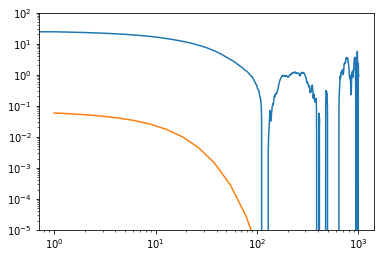

In [14]:
%matplotlib inline
P1=np.array([xyz[:,(xx+1)*50-1,:]-xyz[:,xx*50,:] for xx in range(16)])
# print(P1.shape)
ts=np.arange(0,P1.shape[1],1)
Pav=np.mean([msd_fft(P1[xx])[1] for xx in range(16)],axis=0)
# print(Pav.shape)
plt.loglog(ts,Pav)
plt.loglog(np.logspace(0,3,20),[Rot_corr(xx,1,0,10,10,100) for xx in np.logspace(0,3,20)])

plt.ylim(1e-5,1e2)
# Rot_corr(10,1,1,10,10,100)

In [109]:
T=2e6*100*1e-3
print(tau_p(20,10,100),T/2)

0.025330295910584444 100000.0


In [17]:
import numpy as np
b=np.array([np.array([1,2,3]),np.array([7,2,1])])
b[1]
np.sum(b,axis=0)

array([8, 4, 4])